# Histogram
Build out histrograms to count distributions of scores for comparison. Notice how CVSS is heavily weight towards alerting critical CVEs. This becomes overwhelming and evidence shows that distributions that have less criticals to prioritise improves remediation efforts.

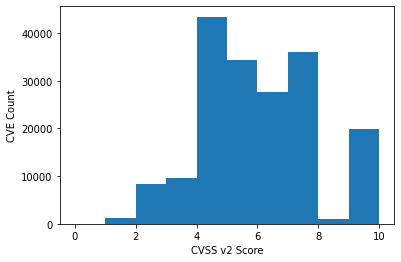

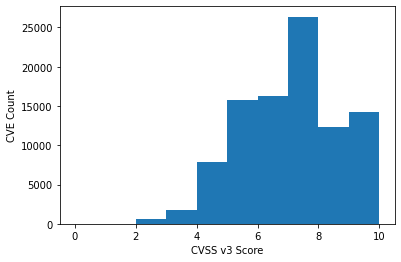

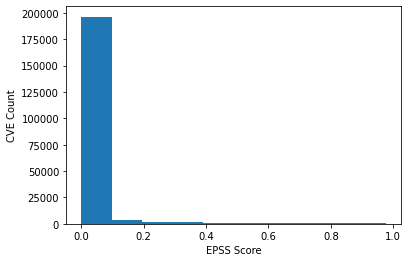

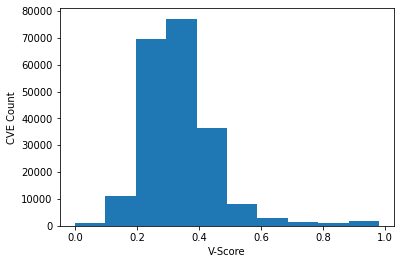

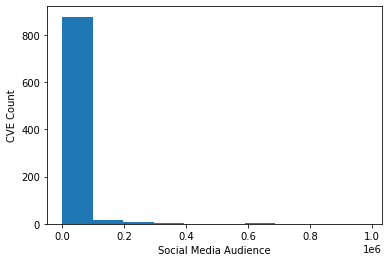

In [33]:
import json

# Opening JSON file
f = open('../data/cve.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)
 
# Iterating through the json list and populate histograms
x_cvssv2 = []
x_cvssv3 = []
x_epss = []
x_vscore = []
x_social_media = []
for i in data['cves']:
    if i['cvssv2'] is not None:
        x_cvssv2.append(i['cvssv2'])
    if i['cvssv3'] is not None:
        x_cvssv3.append(i['cvssv3'])
    if i['epss'] is not None:
        x_epss.append(i['epss'])
    if i['v-score'] is not None:
        x_vscore.append(i['v-score'])
    if i['social_media_audience'] is not None:
        x_social_media.append(i['social_media_audience'])

plt.hist(x_cvssv2)
plt.xlabel("CVSS v2 Score")
plt.ylabel("CVE Count")
plt.show()

plt.hist(x_cvssv3)
plt.xlabel("CVSS v3 Score")
plt.ylabel("CVE Count")
plt.show()

plt.hist(x_epss)
plt.xlabel("EPSS Score")
plt.ylabel("CVE Count")
plt.show()

plt.hist(x_vscore)
plt.xlabel("V-Score")
plt.ylabel("CVE Count")
plt.show()

plt.hist(x_social_media)
plt.xlabel("Social Media Audience")
plt.ylabel("CVE Count")
plt.show()
 
# Closing file
f.close()